# Using CNN for dolphin whistle classification

Import relevant packages. Set up the virtual environment as specified in the README file to avoid "dependency-hell".

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models  # For specifying the type of layer (Dense)

from sklearn.metrics import classification_report
from pathlib import Path


# Generate Training, Validation and Test Datasets
Before running the following cell, change the relative paths to the folders on your machine.

In [3]:
TRAINING_DATA_DIR = Path("model_test_train/train")
TEST_DATA_DIR = Path("model_test_train/test")

X, Y = 413, 202
IMAGE_SHAPE = (Y, X) # (row, col) format for imshow and (height, width) for ImageDataGenerator

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, validation_split=0.20
)  # https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, subset="training", shuffle=True, target_size=IMAGE_SHAPE
)

validation_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, subset="validation", shuffle=True, target_size=IMAGE_SHAPE
)

test_generator = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    TEST_DATA_DIR, shuffle=True, target_size=IMAGE_SHAPE
)

Found 1510 images belonging to 3 classes.
Found 377 images belonging to 3 classes.
Found 473 images belonging to 3 classes.


# Visualise the inputs
This block is non-essential, but it helps to see what your input actually looks like to check that you are using the right ones.

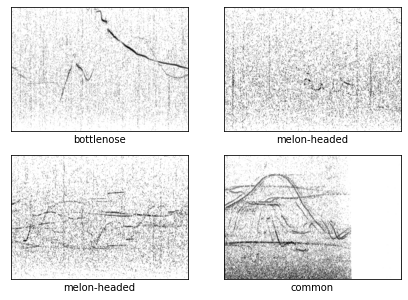

Shape of images:  (32, 202, 413, 3)


In [7]:
# Visualise the datasets
images = iter(train_generator[0][0])
labels = iter(train_generator[0][1])

classes = dict((v, k) for k, v in (train_generator.class_indices).items())

fig, ax = plt.subplots(2, 2, figsize=(7, 5))
for sp in ax.reshape(-1):
    sp.set_xticks([])
    sp.set_yticks([])
    sp.imshow(next(images), aspect="auto")
    label_index = np.where(next(labels) == 1)[0][0]
    sp.set_xlabel(classes.get(label_index))
plt.show()
fig.savefig("image.pdf")
print("Shape of images: ", train_generator[0][0].shape)

## Build a CNN model and stack the layers.

In [10]:
model = models.Sequential()
KERNEL_SIZE = (3, 3) # 3x3 is the optimal size of a kernel 3x3 as agreed by the computing community
INPUT_SHAPE = (X, Y, 3)

model.add(layers.Conv2D(16, KERNEL_SIZE, activation="relu", input_shape=INPUT_SHAPE))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation="relu"))
model.add(BatchNormalization())

# Add fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(layers.Dense(3, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 411, 200, 16)      448       
                                                                 
 batch_normalization_4 (Batc  (None, 411, 200, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 205, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 203, 98, 16)       2320      
                                                                 
 batch_normalization_5 (Batc  (None, 203, 98, 16)      64        
 hNormalization)                                                 
                                                      

# Train the model

In [11]:
# Initialising the model
print("[INFO] compiling model...")
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)  # can play with different parameters

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size
NUM_EPOCHS = 10
es = EarlyStopping("val_loss", mode="min", verbose=1, patience=5)

# Training the network
print("[INFO] training network for {} epochs...".format(NUM_EPOCHS))
history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=NUM_EPOCHS,
    callbacks=[es],
)


[INFO] compiling model...
[INFO] training network for 10 epochs...
Epoch 1/10
47/47 [==============================] - 84s 2s/step - loss: 0.1363 - accuracy: 0.9520 - val_loss: 14.9872 - val_accuracy: 0.2330
Epoch 2/10
47/47 [==============================] - 82s 2s/step - loss: 0.0193 - accuracy: 0.9980 - val_loss: 2.9233 - val_accuracy: 0.3381
Epoch 3/10
47/47 [==============================] - 67s 1s/step - loss: 0.0196 - accuracy: 0.9973 - val_loss: 7.3796 - val_accuracy: 0.3295
Epoch 4/10
47/47 [==============================] - 45s 963ms/step - loss: 0.0082 - accuracy: 0.9993 - val_loss: 6.4862 - val_accuracy: 0.3182
Epoch 5/10
47/47 [==============================] - 45s 964ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 6.1660 - val_accuracy: 0.3267
Epoch 6/10
47/47 [==============================] - 46s 969ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 5.9725 - val_accuracy: 0.3210
Epoch 7/10
47/47 [==============================] - 46s 980ms/step - loss: 0.0250 -

# Evaluating the Network

**Validation and training accuracy:**

[INFO] evaluating network...
15/15 - 4s - loss: 0.2077 - accuracy: 0.9302 - 4s/epoch - 274ms/step
----- Evaluation Summary statistics -----
Test accuracy =  0.930232584476471
Test loss =  0.20774541795253754


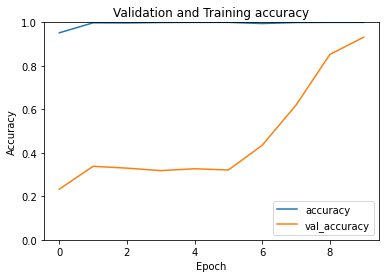

In [12]:
# Evalutate the network - use validation set
print("[INFO] evaluating network...")

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.title("Validation and Training accuracy")
plt.legend(loc="lower right")

test_loss, test_acc = model.evaluate(
    test_generator, verbose=2
)  # Check the return values for this

# SUMMARY STATISTICS
print("----- Evaluation Summary statistics -----")
print("Test accuracy = ", test_acc)
print("Test loss = ", test_loss)


**Validation and Training Loss:**

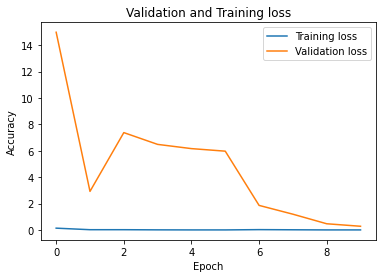

In [13]:
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.title("Validation and Training loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# plt.ylim([0, 1])
plt.legend()


In [20]:
print("[INFO] Predict with network...")
model = keras.models.load_model("2022-03-27-eric.model")
test_generator.reset()
test_labels = test_generator.classes
array_of_class_names = np.array(list(classes.values()))
y_hat = model.predict(test_generator)
print(
    classification_report(
        test_labels, y_hat.argmax(axis=1), target_names=array_of_class_names
    )
)

[INFO] Predict with network...
              precision    recall  f1-score   support

  bottlenose       0.29      0.38      0.33       108
      common       0.30      0.28      0.29       152
melon-headed       0.42      0.38      0.40       213

    accuracy                           0.35       473
   macro avg       0.34      0.35      0.34       473
weighted avg       0.35      0.35      0.35       473



## Save or load model
The current naming format has been decided to be "date-modelname".

In [15]:
from datetime import date
today = date.today()

Today's date: 2022-03-27


In [17]:
# Save the trained model -> could save just the weights or the entire architecture
model_name = ""
model.save(str(today) + '.model')
# loaded_model = keras.models.load_model('/content/drive/MyDrive/16_03_2021_basic_classifier.model')

2022-03-27 18:28:55.644970: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: 2022-03-27.model/assets
